In [17]:
import pickle
import pandas as pd
import torch
import matplotlib.pyplot as plt

import python.voxels as voxels
import python.RNN as RNN
import python.clustering as cl

graph_size = (20,8)

project_folder = "veleval"

In [2]:
with open("./files/"+project_folder+"/data_processed/osmnx_pathfinding_simplified.df",'rb') as infile:
    df_pathfinding = pickle.load(infile)
with open("./files/"+project_folder+"/clustering/dbscan_observations.tab",'rb') as infile:
    tab_clusters = pickle.load(infile)
with open("./files/"+project_folder+"/clustering/voxels_clustered_osmnx.dict",'rb') as infile:
    dict_voxels = pickle.load(infile)
with open("./files/"+project_folder+"/neural_networks/saved/network.param",'rb') as infile:
    param = pickle.load(infile)
with open("./files/"+project_folder+"/neural_networks/saved/num_test.tab",'rb') as infile:
    tab_num_test = pickle.load(infile)
    

size_data = 1

df = df_pathfinding

tab_routes_voxels, _, _ = voxels.generate_voxels(df, df.iloc[0]["route_num"], df.iloc[-1]["route_num"])
tab_routes_voxels_int = []

df_voxels = pd.DataFrame()
df_voxels_train = pd.DataFrame()

dict_clusters = cl.tab_clusters_to_dict(tab_clusters)

network = RNN.RNN_LSTM(size_data, max(tab_clusters)+1, param.hidden_size, param.num_layers, param.bidirectional, param.dropout)
network.load_state_dict(torch.load("files/"+project_folder+"/neural_networks/saved/network_temp.pt"))
network.eval()


RNN_LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
  (out1): Linear(in_features=256, out_features=128, bias=True)
  (out2): Linear(in_features=128, out_features=74, bias=True)
  (out3): Linear(in_features=128, out_features=74, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0, inplace=False)
)

In [3]:
print(len(tab_num_test))

159


In [4]:
tab_results = []
tab_routes_voxels_int = []
for i in range(len(tab_routes_voxels)):
    nb_vox = 0
    tab_routes_voxels_int.append([])
    route = tab_routes_voxels[i]
    for vox in route:
        if(nb_vox%param.voxels_frequency==0): #(len(tab_routes_voxels_int[i])==0 or tab_routes_voxels_int[i][-1][0] != dict_voxels[vox]["cluster"]): 
            points = [dict_voxels[vox]["cluster"]+1]
            tab_routes_voxels_int[i].append(points)
        nb_vox += 1
    tab_routes_voxels_int[i] = torch.Tensor(tab_routes_voxels_int[i])
data = torch.nn.utils.rnn.pad_sequence(tab_routes_voxels_int, batch_first=True)

In [71]:
nb_prediction_test = 0
nb_good_prediction_test = 0
nb_prediction_train = 0
nb_good_prediction_train = 0

tab_results_test = []
tab_results_train = []

for i in range(len(data)):

    if(tab_clusters[i] != -1):
        tens_route = data[i].unsqueeze(0)
        target = torch.LongTensor(tab_clusters[i])
        output = network(tens_route)
        pred = output.argmax(dim=1, keepdim=True)


        if(i in tab_num_test):
            tab_results_test.append({"probabilities": output.squeeze(), "good_result": pred==tab_clusters[i],
                                     "cluster": tab_clusters[i]})
            nb_prediction_test+=1
            if(pred==tab_clusters[i]):
                nb_good_prediction_test+=1
        else:
            tab_results_train.append({"probabilities": output.squeeze(), "good_result": pred==tab_clusters[i],
                         "cluster": tab_clusters[i]})
            nb_prediction_train+=1
            if(pred==tab_clusters[i]):
                nb_good_prediction_train+=1
    
            
print("Good train predict:", nb_good_prediction_train/nb_prediction_train*100, "%")
print("Good test predict:", nb_good_prediction_test/nb_prediction_test*100, "%")

Good train predict: 97.87556904400607 %
Good test predict: 71.0691823899371 %


In [21]:
tab_success_train = []
tab_fail_train = []

tab_success_test = []
tab_fail_test = []

for res in tab_results_train:
    if(res["good_result"]):
        tab_success_train.append(res["cluster"])
    else:
        tab_fail_train.append(res["cluster"])
        
for res in tab_results_test:
    if(res["good_result"]):
        tab_success_test.append(res["cluster"])
    else:
        tab_fail_test.append(res["cluster"])




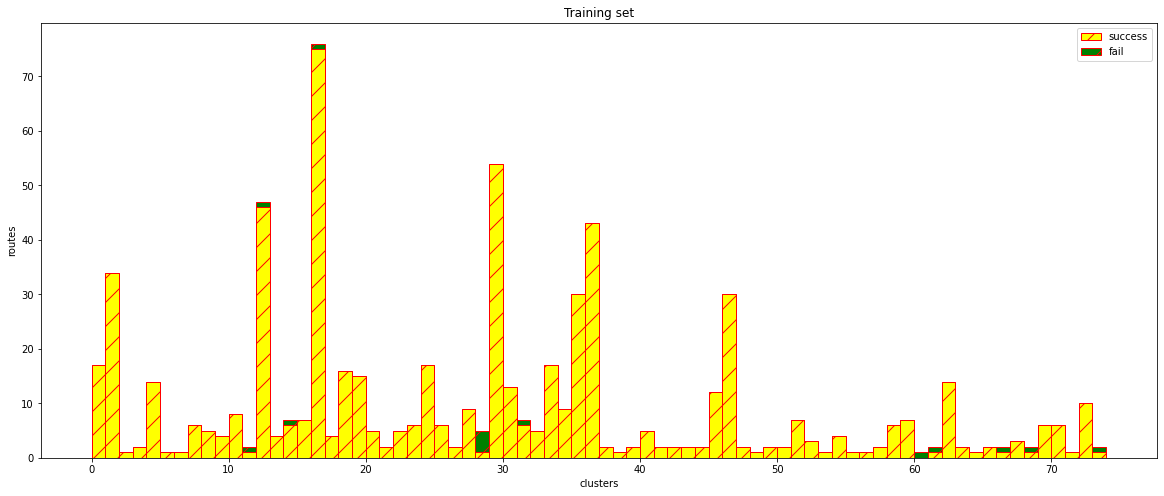

In [22]:
fig = plt.figure(figsize=graph_size)
plt.hist([tab_success_train, tab_fail_train],range(0, max(tab_clusters)+2), color = ['yellow', 'green'],
            edgecolor = 'red', hatch = '/', label = ['success', 'fail'],
            histtype = 'barstacked')
plt.ylabel('routes')
plt.xlabel('clusters')
plt.title('Training set')
plt.legend()

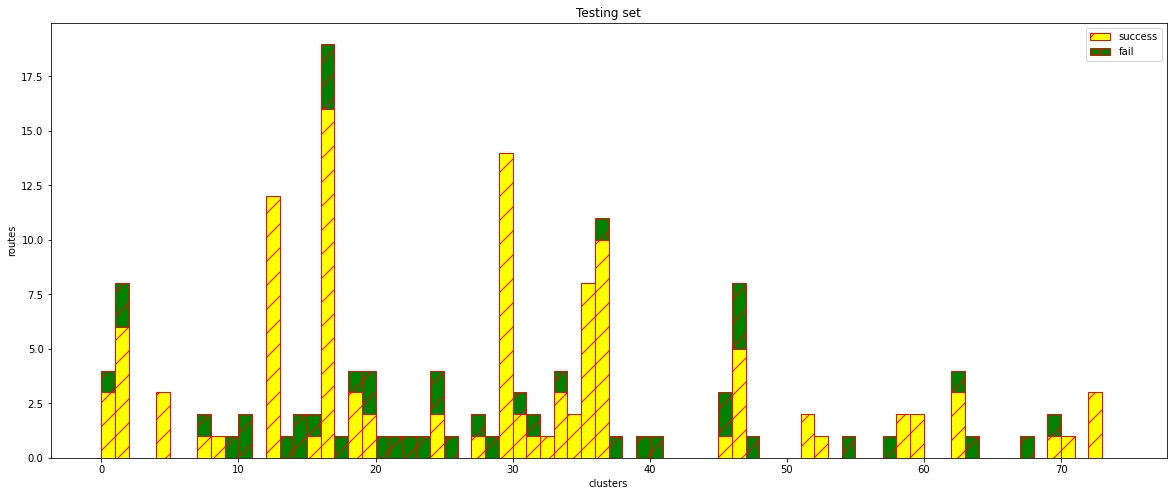

In [24]:
fig = plt.figure(figsize=graph_size)
plt.hist([tab_success_test, tab_fail_test],range(0, max(tab_clusters)+2), color = ['yellow', 'green'],
            edgecolor = 'red', hatch = '/', label = ['success', 'fail'],
            histtype = 'barstacked')
plt.ylabel('routes')
plt.xlabel('clusters')
plt.title('Testing set')
plt.legend()

In [91]:
prob_fail_train = []
prob_fail_test = []


for res in tab_results_train:
    if(not (res["good_result"])):
        prob_fail_train.append([])
        for i in range(len(res["probabilities"].tolist())):
            prob_fail_train[-1].append(10**res["probabilities"].tolist()[i])

for res in tab_results_test:
    if(not(res["good_result"])):
        prob_fail_test.append([])
        for i in range(len(res["probabilities"].tolist())):
            prob_fail_test[-1].append(10**res["probabilities"].tolist()[i])

[1.9988723692217865e-20, 4.568492043973187e-19, 1.915330518299567e-14, 6.17943641490475e-16, 0.0007780643728019849, 4.817156503361127e-19, 5.434288712048149e-09, 6.334432966079537e-08, 9.256481187995169e-11, 1.1399685549340984e-05, 5.747582909764519e-12, 1.7271856447860484e-16, 1.5303511284405221e-07, 1.5758799030389868e-14, 0.00040849477355197917, 2.134012357262476e-17, 7.480127431687813e-09, 0.0023088523865428512, 3.4245168243300033e-13, 2.3123812979854545e-10, 1.232261870813926e-07, 1.0590318449200791e-12, 0.19779244224556444, 6.989316997453845e-22, 0.009839517545321308, 5.60503167994748e-09, 1.5097399566444533e-08, 1.835812309596714e-07, 4.021616321339756e-13, 4.318122059081255e-13, 1.7839310284910936e-10, 4.833378786028791e-10, 6.369729906091119e-13, 5.752178867053975e-19, 2.5147983027419708e-17, 1.3405414136698478e-10, 1.773825540977898e-26, 9.343190933548581e-14, 1.5645427553528635e-13, 2.821434488226288e-15, 2.0986796148793045e-12, 2.7193160517701705e-13, 2.0917138940767135e-12

[]

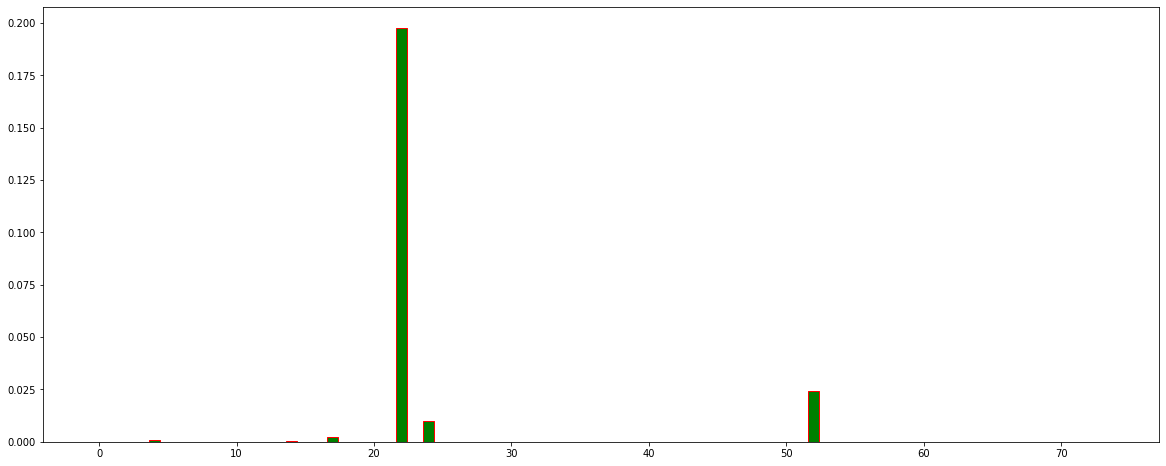

In [94]:
num_fail = 2
print(prob_fail_test[num_fail])
fig = plt.figure(figsize=graph_size)
plt.bar(range(len(prob_fail_test[num_fail])), prob_fail_test[num_fail], color='green', edgecolor = 'red')
plt.plot()